### **GPU cehck**

In [61]:
import tensorflow as tf
import tensorflow.keras.backend as K
tf.test.is_built_with_cuda()
tf.config.list_physical_devices('GPU')
tf.sysconfig.get_build_info()

OrderedDict([('cpu_compiler',
              '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614534878484/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'),
             ('cuda_compute_capabilities',
              ['compute_35',
               'compute_52',
               'compute_60',
               'compute_61',
               'compute_70',
               'compute_75']),
             ('cuda_version', '10.1'),
             ('cudnn_version', '7'),
             ('is_cuda_build', True),
             ('is_rocm_build', False)])

## **Module**

In [177]:
from datetime import datetime
import os
import re
import gc
import pickle
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from functools import reduce

from sklearn.manifold import Isomap
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

import matplotlib.pyplot as plt
from matplotlib_venn import venn3_unweighted
import umap.umap_ as umap

# keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

## **UDF**

In [77]:
def cancer_select(cols, cancer_type):
    # phenotype
    phe1 = pd.read_csv("https://gdc-hub.s3.us-east-1.amazonaws.com/download/GDC-PANCAN.basic_phenotype.tsv.gz", sep="\t")
    phe1 = phe1.loc[phe1.program == "TCGA", :].loc[:, ['sample', 'sample_type', 'project_id']].drop_duplicates(['sample'])
    phe1['sample'] =  phe1.apply(lambda x : x['sample'][:-1], axis=1)
    phe2 = pd.read_csv("https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA_phenotype_denseDataOnlyDownload.tsv.gz", sep="\t")
    ph_join = pd.merge(left = phe2 , right = phe1, how = "left", on = "sample").dropna(subset=['project_id'])
    
    if cancer_type == "PAN" or cancer_type == "PANCAN":
        filterd = ph_join.loc[ph_join['sample_type_y'] == "Primary Tumor", :]
        sample_barcode = filterd["sample"].tolist()
    else:
        filterd = ph_join.loc[(ph_join['sample_type_y'] == "Primary Tumor") & (ph_join['project_id'] == "TCGA-" + cancer_type) , :]
        sample_barcode = filterd["sample"].tolist()
        
    intersect_ = list(set(cols).intersection(sample_barcode))
    
    return intersect_

def non_zero_column(DF):
    sample_cnt = int(len(DF.columns) * 0.2)
    zero_row = dict(DF.isin([0]).sum(axis=1))
    non_remove_feature = list()

    for key, value in zero_row.items():
        if value < sample_cnt:
            non_remove_feature.append(key)
    
    return non_remove_feature

def load_tcga_dataset(pkl_path, raw_path, cancer_type, norm):
    
    if os.path.isfile(pkl_path + "/" + cancer_type + "_omics.pkl"):
        omics = pd.read_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")

        # sep
        rna = pd.read_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")
        mirna = pd.read_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")
        mt = pd.read_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
    else :
        # RNA gene expression
        col = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)
        df_chunk = pd.read_csv(raw_path + "tcga_RSEM_Hugo_norm_count.gz",
                     sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        rna = pd.concat([chunk for chunk in df_chunk])
        rna = rna[rna.index.isin(non_zero_column(rna))].T
        
        rna.to_pickle(pkl_path + "/" + cancer_type + "_rna.pkl")

        # miRNA expression
        col = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mirna = pd.concat([chunk for chunk in df_chunk])
        mirna = mirna[mirna.index.isin(non_zero_column(mirna))].T
        
        mirna.to_pickle(pkl_path + "/" + cancer_type + "_mirna.pkl")

        # methylation
        col = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                     sep = "\t", index_col=0, nrows=0).columns.to_list()
        use_col = ['sample'] + cancer_select(cols=col, cancer_type=cancer_type)

        df_chunk = pd.read_csv(raw_path + "jhu-usc.edu_PANCAN_HumanMethylation450.betaValue_whitelisted.tsv.synapse_download_5096262.xena.gz",
                         sep = "\t", index_col=0, iterator=True, chunksize=50000, usecols=use_col)
        mt = pd.concat([chunk for chunk in df_chunk])

        mt_map = pd.read_csv(raw_path + "probeMap_illuminaMethyl450_hg19_GPL16304_TCGAlegacy", sep="\t")

        mt_join = pd.merge(mt, mt_map, how = "left", left_on = "sample", right_on = "#id")\
                 .drop(['chrom', 'chromStart', 'chromEnd', 'strand', '#id'], axis=1)
        mt_join = mt_join[mt_join.gene != "."]
        mt_join.dropna(subset = ["gene"], inplace=True)

        # gene mean 
        mt_join_gene_filter = mt_join.groupby(['gene']).mean()
        mt_join_gene_filter = mt_join_gene_filter[mt_join_gene_filter.index.isin(non_zero_column(mt_join_gene_filter))].T
        
        mt_join_gene_filter.to_pickle(pkl_path + "/" + cancer_type + "_mt.pkl")
        
        # intersect
        venn3_unweighted([set(rna.index), set(mirna.index), set(mt_join_gene_filter.index)], ('RNA', 'miRNA', 'Methylation'))
        plt.show()
        
        # set same column for merge
        rna['sample'] = rna.index
        mirna['sample'] = mirna.index
        mt_join_gene_filter['sample'] = mt_join_gene_filter.index

        # data join
        merge_list = [rna, mirna, mt_join_gene_filter]
        omics = reduce(lambda left, right : pd.merge(left, right, on = "sample"), merge_list)
        omics.set_index('sample', inplace=True)

        # pickle save
        omics.to_pickle(pkl_path + "/" + cancer_type + "_omics.pkl")
    
    # set index
    omics_index = omics.index.to_list()
#     omics = omics.drop(['sample'], axis = 1)
    
    # normalization
    if norm:
        scalerX = StandardScaler()
        scalerX.fit(omics)
        omics_scale = scalerX.transform(omics)
    
    # missing impute
    imputer = KNNImputer(n_neighbors=10)
    omics_impute = imputer.fit_transform(omics_scale)

    omics = pd.DataFrame(omics_impute, columns=omics.columns)
    omics.index = omics_index

    return omics

def root_mean_squared_log_error(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred)) 

def make_Tensorboard_dir(dir_name):
    root_logdir = os.path.join(os.curdir, dir_name) 
    sub_dir_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
    return os.path.join(root_logdir, sub_dir_name)


def createFolder(path):
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError:
        print ('Folder already exists. ' +  path)

## **Preprocessing**

### **File Path**

In [4]:
os.getcwd()

'/home/km/gitworking/Multi-omics-intergration/src'

In [5]:
RAW_file_path = "/home/km/gitworking/Multi-omics-intergration/RAW_DATA/"
PKL_file_path = "/home/km/gitworking/Multi-omics-intergration/pkl/"
MODEL_path = "/home/km/gitworking/Multi-omics-intergration/models/"
TENSORBOARD_PATH = '/home/km/gitworking/Multi-omics-intergration/log'

* **Data-Load**

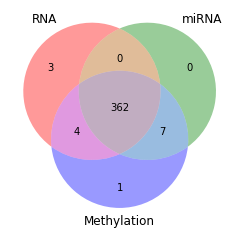

In [173]:
omics = load_tcga_dataset(pkl_path=PKL_file_path, raw_path=RAW_file_path, cancer_type="LIHC", norm=True)

In [28]:
X_train, X_test = train_test_split(omics, test_size = .2, random_state = 21, shuffle=True)

## **Auto-Encoder**

* **end-to-end**

In [131]:
tf.keras.backend.clear_session()

In [132]:
inputs_dim = X_train.shape[1]
encoder = Input(shape = (inputs_dim, ))
e = Dense(1000, activation = "relu")(encoder)
# e = Dense(256, activation = "relu")(e)
e = Dense(500, activation = "relu")(e)

## bottleneck layer
n_bottleneck = 100

## defining it with a name to extract it later
bottleneck_layer = "bottleneck_layer"

# can also be defined with an activation function, relu for instance
bottleneck = Dense(n_bottleneck, name = bottleneck_layer)(e)

## define the decoder (in reverse)
decoder = Dense(500, activation = "relu")(bottleneck)
# decoder = Dense(256, activation = "relu")(decoder)
decoder = Dense(1000, activation = "relu")(decoder)

## output layer
output = Dense(inputs_dim)(decoder)

## model
model = Model(inputs = encoder, outputs = output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58419)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              58420000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
bottleneck_layer (Dense)     (None, 100)               50100     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               50500     
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_4 (Dense)              (None, 58419)             584774

* **Encoder for Latent Vector**

In [133]:
encoder = Model(inputs = model.input, outputs = bottleneck)

In [134]:
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 58419)]           0         
_________________________________________________________________
dense (Dense)                (None, 1000)              58420000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
bottleneck_layer (Dense)     (None, 100)               50100     
Total params: 58,970,600
Trainable params: 58,970,600
Non-trainable params: 0
_________________________________________________________________


* **Model compile & Fit**

In [135]:
# callback function
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
TB_log_dir = make_Tensorboard_dir(TENSORBOARD_PATH)
TensorB = tf.keras.callbacks.TensorBoard(log_dir = TB_log_dir)

# compile & fit
model.compile(loss = "mean_squared_error",
              optimizer = "adam")
history = model.fit(
    X_train,
    X_train,
    batch_size = 128,
    epochs = 30,
    verbose = 0,
    validation_data = (X_test, X_test),
    callbacks=[TensorB]
)
file_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") 
model.save(MODEL_path + "AE_" + file_name)

2022-01-10 13:53:26.399680: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-10 13:53:26.399735: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-10 13:53:26.399976: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NOT_INITIALIZED
2022-01-10 13:53:26.400005: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-01-10 13:53:27.634751: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-01-10 13:53:27.634785: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-01-10 13:53:27.634873: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_NO

INFO:tensorflow:Assets written to: /home/km/gitworking/Multi-omics-intergration/models/AE_20220110-135337/assets


## **Feature Selection**

In [174]:
omic_encoded = encoder.predict(omics)

* **Boruta Algorithm**

In [180]:
def load_data():
    # URLS for dataset via UCI
    train_data_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.data'
    train_label_url='https://archive.ics.uci.edu/ml/machine-learning-databases/madelon/MADELON/madelon_train.labels'

    X_data = pd.read_csv(train_data_url, sep=" ", header=None)
    y_data = pd.read_csv(train_label_url, sep=" ", header=None)
    data = X_data.loc[:, :499]
    data['target'] = y_data[0]
    return data
    
data = load_data()

y = data.pop('target')
X = data.copy().values

In [178]:
rf = RandomForestClassifier(n_jobs=-1, class_weight=None, max_depth=7, random_state=331)

In [175]:
## Define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0)

feat_selector.fit(X, y)

array([[ 41.00028  ,  -0.4341375, -45.90396  , ..., -27.072557 ,
         40.653564 , -18.691336 ],
       [ -7.7648106,  -8.470923 , -16.789984 , ...,  30.082838 ,
         -7.0588255,  17.028498 ],
       [ 36.47052  , -12.612118 ,  -1.4960165, ...,  -0.640674 ,
         25.475704 ,  27.119314 ],
       ...,
       [ 28.62393  ,  19.712914 ,  11.121828 , ...,  17.224785 ,
         -3.8605843,   9.056994 ],
       [ 19.206238 , -25.936945 , -33.949287 , ..., -44.99379  ,
         53.42049  , -36.88635  ],
       [ 42.370995 ,   2.7512624, -29.918505 , ...,  28.240883 ,
        -22.643204 , -19.006882 ]], dtype=float32)

## **Sample Clustering**

* **Latent Vector**

In [142]:
omic_encoded = encoder.predict(omics)

* **Feature Selection**

* Vis for Clustering Using TSNE 2-dim

In [144]:
tsne2 = TSNE(2, metric = "euclidean", random_state = 13).fit_transform(omic_encoded)

/home/km/anaconda3/envs/multiomics/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/km/anaconda3/envs/multiomics/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


* **K-Mean Clustering**

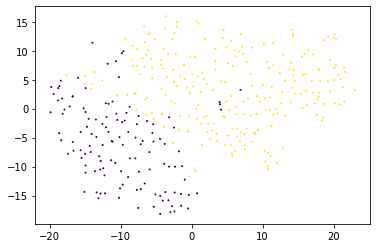

In [147]:
kmeans = KMeans(n_clusters = 2, random_state = 331, max_iter = 1000)
km1 = kmeans.fit_predict(omic_encoded)
plt.scatter(tsne2[:, 0], tsne2[:, 1], c = km1, s = 1)
plt.show()

In [148]:
# clustering index
ae_groups = pd.DataFrame(km1, columns = ['group'])

In [155]:
# 
omics['sample'] = omics.index.to_list()

In [166]:
omics_group_bind = pd.concat([ae_groups.reset_index(drop=True), omics.reset_index(drop=True)], axis=1)

In [168]:
omics_group_bind.set_index('sample', inplace=True)

In [170]:
omics_group_bind.dtypes

group                           int32
RP11-16E12.2_x                float64
RP11-181G12.2                 float64
CPHL1P_x                      float64
TCOF1_x                       float64
                               ...   
snoR1,SNHG19,SNORD60,TRAF7    float64
snoU13,KIF9                   float64
snoU2_19,EIF1AX,snoU2-30      float64
uc_338,SMARCA4                float64
yR211F11.2                    float64
Length: 58420, dtype: object